<a href="https://colab.research.google.com/github/saimani5/Notebooks_for_papers/blob/main/FerroSim_VAE_BO_code_for_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing pyroved for Variational Autoencoder (VAE)
!pip install pyroved==0.2.3

#GPim for Bayesian Optimization
!pip install gpim

#Install the FerroSIM package
!pip install -e git+https://github.com/ramav87/FerroSim.git@rama_dev_updated#egg=FerroSim
#Note: Once you install, restart the runtime, but do not re-run this cell.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 718 kB 49.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining FerroSim from git+https://github.com/ramav87/FerroSim.git@rama_dev_updated#egg=FerroSim
  Cloning https://github.com/ramav87/FerroSim.git (to revision rama_dev_updated) to ./src/ferrosim
  Running command git clone -q https://github.com/ramav87/FerroSim.git /content/src/ferrosim
  Running command git checkout -b rama_dev_updated --track origin/rama_dev_updated
  Switched to a new branch 'rama_dev_updated'
  Branch 'rama_dev_updated' set up to track remote branch 'rama_dev_updated' from 'origin'.
  Running setup.py develop for FerroSim


In [ ]:
# Importing the packages
import pyroved as pv
import gpim
from joblib import Parallel, delayed
from ferrosim import Ferro2DSim
import torch
import matplotlib.pyplot as plt

from sklearn import decomposition
import numpy as np
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

from numpy import exp, pi, sqrt
import math
from matplotlib import cm

from numpy.polynomial import Legendre
torch.manual_seed(0)

# Lengendre Polynomial Analysis

In [ ]:
# Function to generate random functions from legendre polynomials

def generate_1Dspectra_Legendre(degree: int = 15, nsamples: int = 5000) -> torch.Tensor:
    
    x = torch.linspace(-1, 1, 100)

    #Generate the polynomial coefficients for all the datapoints
    legend_coeff = np.random.rand(degree, nsamples)

    #Scaling the coefficients to make the generated functions practical
    norm_coeff = np.zeros_like(legend_coeff)
    for nc in np.arange(nsamples):
        norm_coeff[:,nc] = legend_coeff[:,nc]/np.array(1+np.arange(degree))

    legend_coeff = torch.from_numpy(norm_coeff)      

    dataset = []
    a_real = []    #Amplitudes of each datapoint/function

    for i in range(nsamples):
        noise = torch.randint(0, 50, (1,)) / 1e3    #Adding noise
        #a = torch.tensor([1.0]) 
        a = torch.randint(50,100, size=(1,)) / 100  #Amplitude betweeen [0.5, 1]

        #g = a*gaussian(x, mu[i], sig[i]) + noise * torch.randn(size=(len(x),))
        g = a * Legendre(legend_coeff[:,i])
        data_t = np.array([g(xi) for xi in x]) 
        data_t = torch.from_numpy(data_t) + noise * torch.randn(size=(len(x),))   #Adding noise
        dataset.append(data_t)
        #print(len(data_t), len(dataset))
        a_real.append(a)

    dataset = torch.cat(dataset).reshape(nsamples,100)
    a_real = torch.cat(a_real)   #Ground state amplitudes

    # dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())
    return dataset, legend_coeff, a_real

In [ ]:
train_data, legend_coeff, a_real = generate_1Dspectra_Legendre()
print(train_data.shape, legend_coeff.shape, a_real.shape)
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

torch.Size([5000, 100]) torch.Size([15, 5000]) torch.Size([5000])


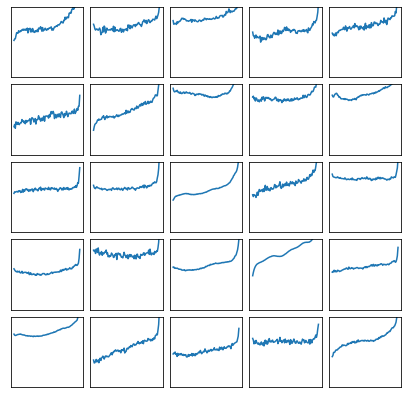

In [ ]:
#Plotting a few spectra
fig, axes = plt.subplots(5, 5, figsize=(7, 7),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

x = torch.linspace(-1, 1, 100)
for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x, y[0, 0])
    ax.set_ylim(-1,1)

We have the dataset and dataloader ready. Now we will train the VAE

In [ ]:
# set the dimension of the spectra
in_dim = (100,)

# Initialize invariant VAE
vae = pv.models.iVAE(in_dim, latent_dim=2, coord=0,
                      sampler_d="gaussian", decoder_sig=.1, sigmoid_d=False,
                      seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(200):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 41.8510
Epoch: 2 Training loss: -94.8911
Epoch: 3 Training loss: -111.3726
Epoch: 4 Training loss: -112.5091
Epoch: 5 Training loss: -112.8934
Epoch: 6 Training loss: -113.0443
Epoch: 7 Training loss: -112.1651
Epoch: 8 Training loss: -113.2857
Epoch: 9 Training loss: -113.4640
Epoch: 10 Training loss: -113.3582
Epoch: 11 Training loss: -113.7981
Epoch: 12 Training loss: -113.9793
Epoch: 13 Training loss: -113.9278
Epoch: 14 Training loss: -112.9879
Epoch: 15 Training loss: -114.4830
Epoch: 16 Training loss: -114.3990
Epoch: 17 Training loss: -114.2318
Epoch: 18 Training loss: -114.2327
Epoch: 19 Training loss: -114.5142
Epoch: 20 Training loss: -114.3067
Epoch: 21 Training loss: -114.6362
Epoch: 22 Training loss: -114.7055
Epoch: 23 Training loss: -114.7562
Epoch: 24 Training loss: -114.0967
Epoch: 25 Training loss: -114.5468
Epoch: 26 Training loss: -114.5666
Epoch: 27 Training loss: -114.7655
Epoch: 28 Training loss: -114.6993
Epoch: 29 Training loss: -114.64

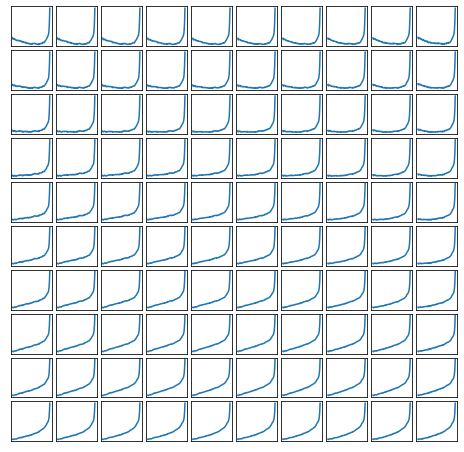

tensor([[0.1185, 0.0887, 0.0863,  ..., 0.2844, 0.4550, 0.7305],
        [0.1910, 0.1627, 0.1603,  ..., 0.3608, 0.5239, 0.8009],
        [0.2549, 0.2275, 0.2263,  ..., 0.4243, 0.5843, 0.8596],
        ...,
        [0.2864, 0.2710, 0.2719,  ..., 1.2065, 1.3915, 1.7571],
        [0.3884, 0.3732, 0.3737,  ..., 1.3201, 1.5065, 1.8749],
        [0.5322, 0.5169, 0.5193,  ..., 1.4855, 1.6833, 2.0612]])

In [ ]:
# Decoded latent space visualization
vae.manifold2d(d=10)

Visualization of Latent Distributions

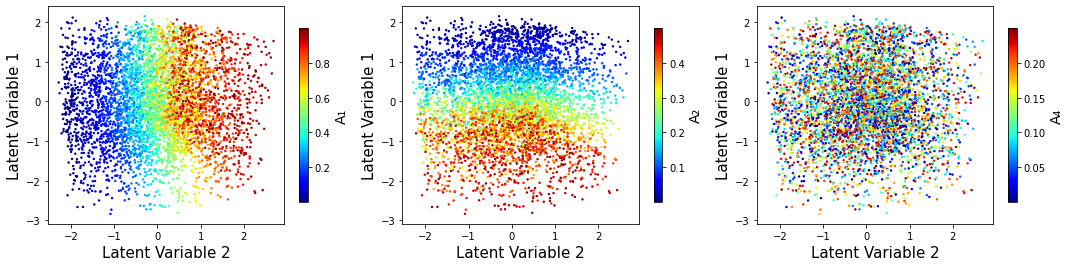

In [ ]:
z_mean, z_sd = vae.encode(train_data)

# Compare ground truth shift and VAE latent variables
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (18,4))

im0 = ax0.scatter(z_mean[:,1], z_mean[:,0], c = legend_coeff[0], s=2, cmap = 'jet')
ax0.set_xlabel('Latent Variable 2', fontsize = 15)
ax0.set_ylabel('Latent Variable 1', fontsize = 15)
# ax0.set_title('alpha', fontsize = 15)
cbar0 = fig.colorbar(im0, ax=ax0, shrink=.8)
cbar0.set_label(u'A\u2081', fontsize=14)

im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c = legend_coeff[1], s=2, cmap = 'jet')
ax1.set_xlabel('Latent Variable 2', fontsize = 15)
ax1.set_ylabel('Latent Variable 1', fontsize = 15)
# ax1.set_title('frequency', fontsize = 15)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label(u'A\u2082', fontsize=14)

im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c = legend_coeff[3], s=2, cmap = 'jet')
ax2.set_xlabel('Latent Variable 2', fontsize = 15)
ax2.set_ylabel('Latent Variable 1', fontsize = 15)
# ax1.set_title('frequency', fontsize = 15)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label(u'A\u2084', fontsize=14)

plt.subplots_adjust(wspace = 0.2)


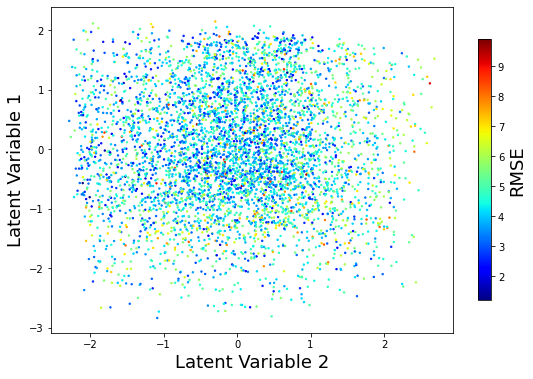

In [ ]:
# Evaluating the RMSE between the input data and the encoded-decoded dataset
# And using the RMSE to color the Latent space distribution

from sklearn.metrics import mean_squared_error

z_mean, z_sd = vae.encode(train_data)
recons_data = vae.decode(z_mean)

rmse = np.sqrt((train_data - recons_data)**2).sum(dim = 1)

fig, (ax0) = plt.subplots(1,1, figsize = (9,6))

im0 = ax0.scatter(z_mean[:,1], z_mean[:,0], c = rmse, s=2, cmap = 'jet')
ax0.set_xlabel('Latent Variable 2', fontsize = 18)
ax0.set_ylabel('Latent Variable 1', fontsize = 18)
# ax0.set_title('alpha', fontsize = 15)
cbar0 = fig.colorbar(im0, ax=ax0, shrink=.8)
cbar0.set_label(u'RMSE', fontsize=18)

## Continuity of Latent space

In [ ]:
xdata = np.linspace(-1,1,100)
clist = []
npoint = 100

for l1 in np.linspace(-2,2,npoint):
  for l2 in np.linspace(-2,2,npoint):
    decoded_sample = vae.decode(torch.tensor([l1, l2]).float())
    ydata = np.squeeze(np.array(decoded_sample.T))
    c = Legendre.fit(xdata, ydata, deg=15).coef
    clist.append(c)

clist2 = np.array(clist).reshape(npoint,npoint,16)

(-0.5, 99.5, -0.5, 99.5)

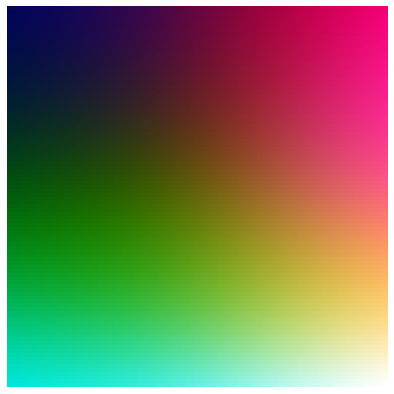

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))
map_coef = (0,1,2)

c0 = clist2[:,:,map_coef[0]]
c1 = clist2[:,:,map_coef[1]]
c2 = clist2[:,:,map_coef[2]]

c0 = (c0-c0.min())/(c0.max()-c0.min())
c1 = (c1-c1.min())/(c1.max()-c1.min())
c2 = (c2-c2.min())/(c2.max()-c2.min())

c_all = np.dstack((c0,c1,c2))

ax.imshow(c_all, origin = 'lower')
ax.axis('off')


## RMSE vs number of latent variables

In [ ]:
# params_real consists the original parameters used to construct the dataset
# First 15 elements are the legendre coefficients used and the last element is the amplitude
params_real = torch.transpose(torch.cat((legend_coeff, torch.unsqueeze(a_real, dim=0)), dim = 0), 0, 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, params_real, 
                                                    test_size=0.2, random_state=42)

train_loader1 = pv.utils.init_dataloader(X_train.unsqueeze(1), batch_size=64)

In [ ]:
from sklearn.metrics import mean_squared_error

# set the dimension of the spectra
in_dim = (100,)
rmse_train,rmse_test = [],[]
latent_dims = [1,2,3,4,5,6,7,8,9,10]

for lat in latent_dims:
  # Initialize invariant VAE
  vae1 = pv.models.iVAE(in_dim, latent_dim=lat, coord=0,
                      sampler_d="gaussian", decoder_sig=.1, sigmoid_d=False,
                      seed=0)

  # Initialize SVI trainer
  trainer = pv.trainers.SVItrainer(vae1)

  # Train for n epochs:
  for e in range(100):
      trainer.step(train_loader1)
      trainer.print_statistics()

  #Encode train and test datasets
  #I don't know why but the following line throws an error
  # z_mean_train, z_sd_train = vae1.encode(X_train)

  #The work around for encoding
  z_train = vae1._encode(X_train)
  z_mean_train, z_sd_train = z_train.split(lat, 1)
  z_test = vae1._encode(X_test)
  z_mean_test, z_sd_test = z_test.split(lat, 1)
  #Decode 
  decoded_sample_train = vae1.decode(z_mean_train)
  decoded_sample_test = vae1.decode(z_mean_test)

  #RMSE
  rmse_train.append(np.sqrt(mean_squared_error(X_train, decoded_sample_train)))
  rmse_test.append(np.sqrt(mean_squared_error(X_test, decoded_sample_test)))

Epoch: 1 Training loss: 55.2582
Epoch: 2 Training loss: -90.9132
Epoch: 3 Training loss: -92.4327
Epoch: 4 Training loss: -91.8710
Epoch: 5 Training loss: -93.2110
Epoch: 6 Training loss: -93.3182
Epoch: 7 Training loss: -93.3285
Epoch: 8 Training loss: -93.7445
Epoch: 9 Training loss: -92.5663
Epoch: 10 Training loss: -93.2415
Epoch: 11 Training loss: -93.3514
Epoch: 12 Training loss: -93.5406
Epoch: 13 Training loss: -93.9929
Epoch: 14 Training loss: -94.0897
Epoch: 15 Training loss: -93.9874
Epoch: 16 Training loss: -93.9393
Epoch: 17 Training loss: -94.1123
Epoch: 18 Training loss: -94.2338
Epoch: 19 Training loss: -94.2317
Epoch: 20 Training loss: -94.1654
Epoch: 21 Training loss: -94.0484
Epoch: 22 Training loss: -94.2006
Epoch: 23 Training loss: -94.4728
Epoch: 24 Training loss: -94.2301
Epoch: 25 Training loss: -94.1638
Epoch: 26 Training loss: -94.3851
Epoch: 27 Training loss: -94.4339
Epoch: 28 Training loss: -94.3891
Epoch: 29 Training loss: -94.5674
Epoch: 30 Training loss:

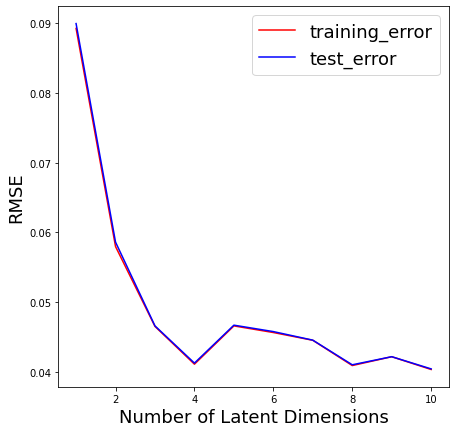

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))
ax.plot(latent_dims, rmse_train, c = 'r', label = 'training_error')
ax.plot(latent_dims, rmse_test, c = 'b', label = 'test_error')
ax.set_xlabel('Number of Latent Dimensions', fontsize = 18)
ax.set_ylabel('RMSE', fontsize = 18)
ax.legend(fontsize = 18)

## Working with wrong trajectories

In [ ]:
x_vec = np.linspace(-1,1,100)
def gen_dataset(nsamples: int = 7500, 
                m_range: list = [0, np.pi],
                c_range: list = [-1.0, 1.0],
                w_range: list = [4*np.pi, 6*np.pi],
                proportion: float = 0.01,
                norm: bool = False) -> np.array:
  
  # Setting the seed for reproducible results
  np.random.seed(521)
  
  nsamples_linear = int((1-proportion)*nsamples)
  nsamples_sin = nsamples - nsamples_linear
  col = np.ones(nsamples)
  

  m = np.random.uniform(low = m_range[0], high = m_range[1],
                        size = nsamples_linear)
  
  c = np.random.uniform(low = c_range[0], high = c_range[1],
                        size = nsamples_linear)
  
  w = np.random.uniform(low = w_range[0], high = w_range[1],
                        size = nsamples_sin)
                                   
  dataset = np.zeros([nsamples, len(x_vec)])
                                   
  for i in range(nsamples):
    if i<nsamples_linear:
      dataset[i] = np.tan(m[i])*x_vec + c[i]
      
    else:
      j = i - nsamples_linear
      dataset[i] = np.sin(w[j]*x_vec)
      col[i] = 15

    #Normalize each datapoint
    if norm:
      dataset[i] = 2*((dataset[i] - np.amin(dataset[i]))/np.ptp(dataset[i])) - 1

  return torch.tensor(dataset).float(), col, m, c

In [ ]:
#Where only 1 percent of the curves are corrupted
train_dataset_1, colors_1, m, c = gen_dataset(proportion = 0.01)
train_loader_1 = pv.utils.init_dataloader(train_dataset_1.unsqueeze(1), batch_size=64)

#Where 10 percent of the curves are corrupted
train_dataset_10, colors_10, m, c = gen_dataset(proportion = 0.1)
train_loader_10 = pv.utils.init_dataloader(train_dataset_10.unsqueeze(1), batch_size=64)

#Where 30 percent of the curves are corrupted
train_dataset_30, colors_30, m, c = gen_dataset(proportion = 0.3)
train_loader_30 = pv.utils.init_dataloader(train_dataset_30.unsqueeze(1), batch_size=64)

In [ ]:
# set the dimension of the spectra
in_dim = (100,)

#Where only 1% of the curves are corrupted
vae_1 = pv.models.iVAE(in_dim, latent_dim=2, coord=0,
                      sampler_d="gaussian", decoder_sig=.1, sigmoid_d=False,
                      seed=521)
trainer_1 = pv.trainers.SVItrainer(vae_1)
for e in range(75):
    trainer_1.step(train_loader_1)
    trainer_1.print_statistics()

#Where 10% of the curves are corrupted
vae_10 = pv.models.iVAE(in_dim, latent_dim=2, coord=0,
                      sampler_d="gaussian", decoder_sig=.1, sigmoid_d=False,
                      seed=521)
trainer_10 = pv.trainers.SVItrainer(vae_10)
for e in range(75):
    trainer_10.step(train_loader_10)
    trainer_10.print_statistics()


#Where 30% of the curves are corrupted
vae_30 = pv.models.iVAE(in_dim, latent_dim=2, coord=0,
                      sampler_d="gaussian", decoder_sig=.1, sigmoid_d=False,
                      seed=521)
trainer_30 = pv.trainers.SVItrainer(vae_30)
for e in range(75):
    trainer_30.step(train_loader_30)
    trainer_30.print_statistics()

Epoch: 1 Training loss: 7231241.5463
Epoch: 2 Training loss: 7113570.0383
Epoch: 3 Training loss: 7044684.3821
Epoch: 4 Training loss: 6989116.7840
Epoch: 5 Training loss: 6962220.6281
Epoch: 6 Training loss: 6895958.0182
Epoch: 7 Training loss: 7129300.1622
Epoch: 8 Training loss: 7107609.4921
Epoch: 9 Training loss: 7060907.3686
Epoch: 10 Training loss: 7164599.9600
Epoch: 11 Training loss: 7036388.1062
Epoch: 12 Training loss: 7000042.7871
Epoch: 13 Training loss: 6908244.5348
Epoch: 14 Training loss: 6949717.1638
Epoch: 15 Training loss: 6882205.0827
Epoch: 16 Training loss: 7109985.5589
Epoch: 17 Training loss: 6789606.6263
Epoch: 18 Training loss: 6777139.2010
Epoch: 19 Training loss: 7086144.8956
Epoch: 20 Training loss: 6906309.2646
Epoch: 21 Training loss: 6769984.2300
Epoch: 22 Training loss: 7037881.6489
Epoch: 23 Training loss: 6832094.3784
Epoch: 24 Training loss: 6853742.0741
Epoch: 25 Training loss: 6917496.7057
Epoch: 26 Training loss: 6928733.2548
Epoch: 27 Training lo

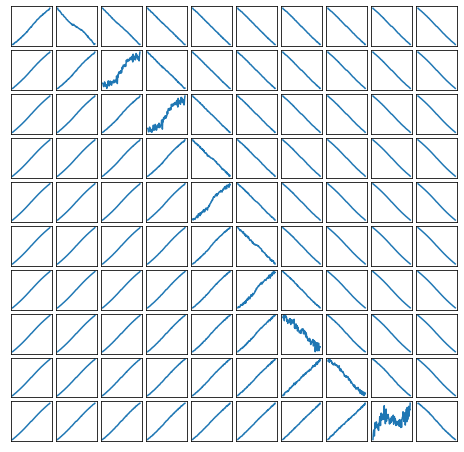

tensor([[-11.6580, -11.6937, -11.6514,  ...,  11.7428,  12.5091,  12.8106],
        [  3.1933,   3.0350,   2.9185,  ...,  -2.1892,  -2.1119,  -2.0922],
        [  6.6575,   6.5173,   6.3641,  ...,  -5.4719,  -5.5659,  -5.5455],
        ...,
        [ -5.4896,  -5.3780,  -5.2785,  ...,   4.4888,   4.3384,   4.7650],
        [ -0.9114,  -0.7622,  -0.6639,  ...,  -0.1146,  -0.1475,   0.0322],
        [ 13.8935,  14.0274,  14.0033,  ..., -14.2361, -14.6096, -14.8066]])

In [ ]:
vae_1.manifold2d(d=10)

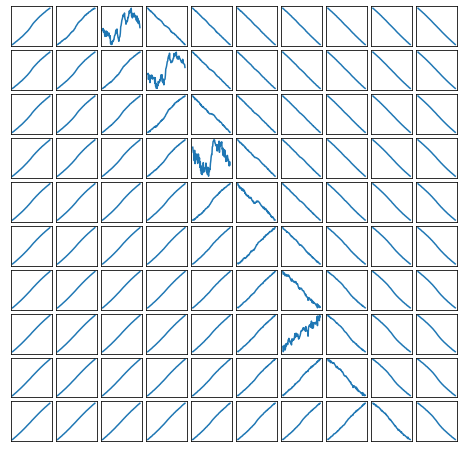

tensor([[-38.3619, -37.6085, -37.1080,  ...,  37.0919,  37.9169,  38.4704],
        [-10.5284, -10.3242, -10.3099,  ...,  10.7429,  11.0049,  10.8910],
        [  0.2505,   0.3204,   0.1844,  ...,   0.5674,   0.4904,   0.3564],
        ...,
        [-14.9840, -15.1023, -14.8165,  ...,  13.6902,  14.4396,  14.5728],
        [ 10.9802,  10.5982,  10.6733,  ..., -11.3485, -11.3720, -11.4949],
        [ 41.1406,  40.3341,  39.8528,  ..., -40.1526, -40.9856, -41.7298]])

In [ ]:
vae_10.manifold2d(d=10)

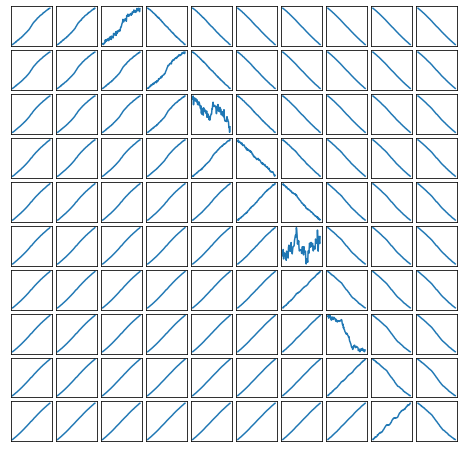

tensor([[-27.6479, -27.0687, -26.8149,  ...,  27.1213,  27.4715,  27.7019],
        [-15.3839, -15.1668, -15.0975,  ...,  15.5865,  15.4661,  15.8746],
        [ -1.0756,  -1.0496,  -1.1407,  ...,   1.7764,   1.5846,   1.8377],
        ...,
        [-32.9139, -32.0232, -31.9765,  ...,  31.4471,  32.0969,  32.7226],
        [ -5.7367,  -5.4587,  -5.5943,  ...,   4.8598,   5.1496,   5.3394],
        [ 24.0266,  23.4639,  23.1160,  ..., -23.5183, -23.7204, -23.8432]])

In [ ]:
vae_30.manifold2d(d=10)

Text(0, 0.5, 'Latent Variable 1')

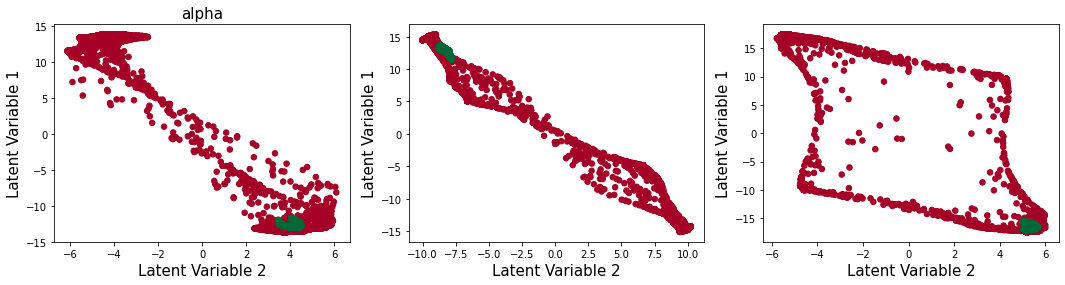

In [ ]:
colors_1 = np.where(colors_1 == 1, 10, colors_1)
colors_10 = np.where(colors_10 == 1, 10, colors_10)
colors_30 = np.where(colors_30 == 1, 10, colors_30)

z_mean_1, z_sd_1 = vae_1.encode(train_dataset_1)
z_mean_10, z_sd_10 = vae_10.encode(train_dataset_10)
z_mean_30, z_sd_30 = vae_30.encode(train_dataset_30)


fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (18,4))

im0 = ax0.scatter(z_mean_1[:,1], z_mean_1[:,0], c = colors_1, s = 3*colors_1, cmap = 'RdYlGn')
ax0.set_xlabel('Latent Variable 2', fontsize = 15)
ax0.set_ylabel('Latent Variable 1', fontsize = 15)
ax0.set_title('alpha', fontsize = 15)


im1 = ax1.scatter(z_mean_10[:,1], z_mean_10[:,0], c = colors_10, s=3*colors_10, cmap = 'RdYlGn')
ax1.set_xlabel('Latent Variable 2', fontsize = 15)
ax1.set_ylabel('Latent Variable 1', fontsize = 15)


im2 = ax2.scatter(z_mean_30[:,1], z_mean_30[:,0], c = colors_30, s=3*colors_30, cmap = 'RdYlGn')
ax2.set_xlabel('Latent Variable 2', fontsize = 15)
ax2.set_ylabel('Latent Variable 1', fontsize = 15)


# plt.subplots_adjust(wspace = 0.3)

# Encoding Electric fields for FerroSIM using VAE

In [ ]:
# Preparing the electric fields
#Curves of the form Aexp(aplha*t)cos(wt)+B

#0 to 5 seconds divided into 1500 datapoints
#The Field for the last 700 points is set to a constant values i.e, E[799]

#We will use t_vec_dummy to normalize the curves
#If we consider just the first seconds in normalization, all the curves with ...
# a +ve alpha will be cut off at 1, To avoid this we will let the curve hit ...
# the next peak and then use it to normalize

t_vec_dummy = np.linspace(0,4,1200)
t_vec = t_vec_dummy[0:900]  #Time used in rvae  
t_vec_ext = t_vec_dummy[0:950]    #Time used in ferrosim


def gen_dataset(nsamples: int = 7500, 
                A_range: list = [0, .75],
                alpha_range: list = [-2.75, 2.75],
                w_range: list = [2*np.pi, (8/3)*np.pi],
                B_range: list = [-0.5, 0.5],
                norm: bool = True) -> np.array:
  
  # Setting the seed for reproducible results
  np.random.seed(171)
  
  A = np.random.uniform(low = A_range[0], high = A_range[1],
                        size = nsamples)
  
  alpha = np.random.uniform(low = alpha_range[0], high = alpha_range[1], 
                            size = nsamples)
                                   
  w = np.random.uniform(low = w_range[0], high = w_range[1], 
                        size = nsamples)
                                   
  B = np.random.uniform(low = B_range[0], high = B_range[1], 
                        size = nsamples)
                                   
  E = np.zeros([nsamples, len(t_vec)])
  for i in range(nsamples):
    
    full_curve = A[i]*np.exp(alpha[i]*t_vec_dummy)*np.cos(w[i]*t_vec_dummy) + B[i]
    
    #Cut off E at 3 sec
    # E[i, 300::] = E[i, 299]

    #Normalize each datapoint
    if norm:
      full_curve_norm = 2*((full_curve - np.amin(full_curve))/np.ptp(full_curve)) - 1
      noise = np.random.normal(loc = 0.0, scale = 0.02,size = len(t_vec_dummy))
      full_curve_norm = full_curve_norm + noise

    E[i] = full_curve_norm[0:900]
  return E, A, alpha, w, B

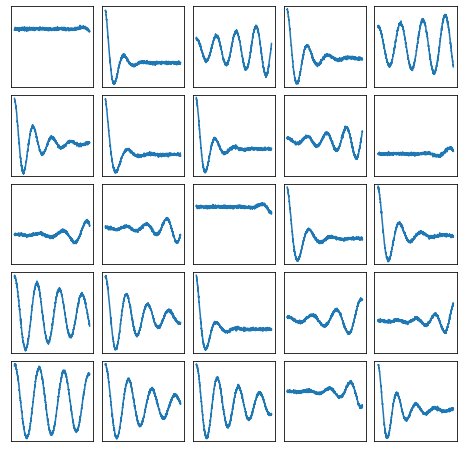

In [ ]:
dataset, A_real, alpha_real, w_real, B_real = gen_dataset()
# Plotting some electric fields
fig, axes = plt.subplots(5, 5, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))


for ax, y in zip(axes.flat, dataset):
    ax.plot(t_vec, y)
    ax.set_ylim (-1.1,1.1)

Training the VAE

In [ ]:
#Getting into torch regime from now
train_data = torch.tensor(dataset).float()
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

# set the dimension of the spectra
in_dim = (900,)

# Initialize invariant VAE
vae = pv.models.iVAE(in_dim, latent_dim=2, coord=0,
                      sampler_d="gaussian", decoder_sig=.1, sigmoid_d=False,
                      seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(75):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 922.3607
Epoch: 2 Training loss: -598.9991
Epoch: 3 Training loss: -795.9188
Epoch: 4 Training loss: -862.4107
Epoch: 5 Training loss: -909.3809
Epoch: 6 Training loss: -959.2046
Epoch: 7 Training loss: -1008.8504
Epoch: 8 Training loss: -1053.0353
Epoch: 9 Training loss: -1069.6126
Epoch: 10 Training loss: -1076.1715
Epoch: 11 Training loss: -1026.1358
Epoch: 12 Training loss: -977.2553
Epoch: 13 Training loss: -866.1262
Epoch: 14 Training loss: -1051.2369
Epoch: 15 Training loss: -999.7733
Epoch: 16 Training loss: -1005.9716
Epoch: 17 Training loss: -1116.8086
Epoch: 18 Training loss: -1112.3078
Epoch: 19 Training loss: -1138.1564
Epoch: 20 Training loss: -1129.5482
Epoch: 21 Training loss: -1125.1841
Epoch: 22 Training loss: -1145.0251
Epoch: 23 Training loss: -1150.7206
Epoch: 24 Training loss: -1144.2206
Epoch: 25 Training loss: -1147.2407
Epoch: 26 Training loss: -1129.1566
Epoch: 27 Training loss: -1139.0677
Epoch: 28 Training loss: -1138.0129
Epoch: 29 T

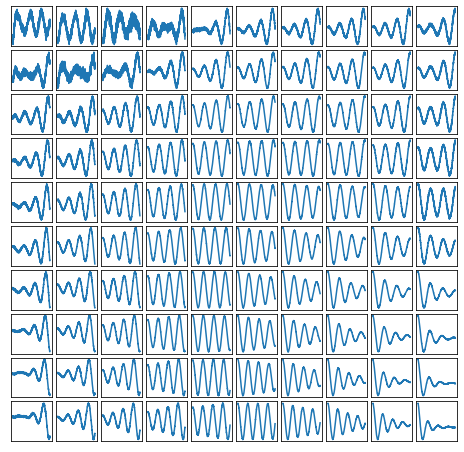

tensor([[-0.2120, -0.2901, -0.2109,  ...,  0.1201,  0.2014,  0.1030],
        [-0.1061, -0.1593, -0.1269,  ...,  0.0982,  0.0200,  0.0168],
        [-0.0568, -0.0906, -0.0657,  ...,  0.0783, -0.0588, -0.0349],
        ...,
        [ 0.9918,  1.0005,  0.9848,  ..., -0.1111, -0.1152, -0.1172],
        [ 0.9804,  0.9888,  0.9733,  ..., -0.1899, -0.1905, -0.2035],
        [ 0.9842,  0.9882,  0.9672,  ..., -0.3355, -0.3421, -0.3525]])

In [ ]:
# Origin is at the center
# L1 is on y axis, increasing while going upwards
# L2 is on x axis, increasing towards right

vae.manifold2d(d=10)#, z_coord = [-8, 8, -5, 5])

Latent Space Distributions

tensor(-5.3521) tensor(5.2746)
tensor(-5.8364) tensor(3.2263)


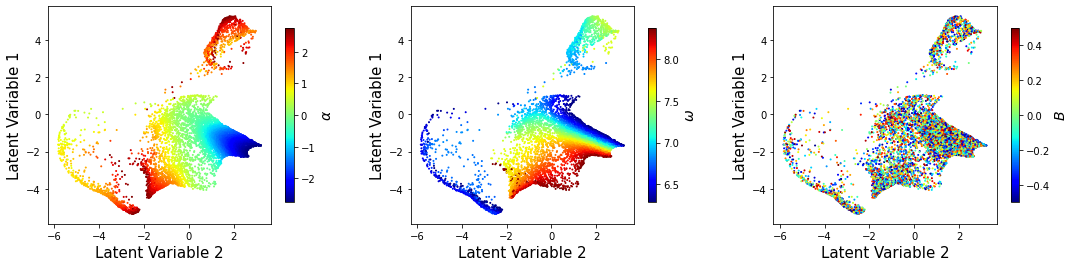

In [ ]:
z_mean, z_sd = vae.encode(train_data)
print(torch.min(z_mean[:,0]), torch.max(z_mean[:,0]))
print(torch.min(z_mean[:,1]), torch.max(z_mean[:,1]))

# Compare ground truth shift and VAE latent variables
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (18,4))

im0 = ax0.scatter(z_mean[:,1], z_mean[:,0], c = alpha_real, s=1, cmap = 'jet')
ax0.set_xlabel('Latent Variable 2', fontsize = 15)
ax0.set_ylabel('Latent Variable 1', fontsize = 15)
# ax0.set_title('alpha', fontsize = 15)
cbar0 = fig.colorbar(im0, ax=ax0, shrink=.8)
cbar0.set_label(r"$\alpha$", fontsize=14)

im1 = ax1.scatter(z_mean[:,1], z_mean[:,0], c = w_real, s=1, cmap = 'jet')
ax1.set_xlabel('Latent Variable 2', fontsize = 15)
ax1.set_ylabel('Latent Variable 1', fontsize = 15)
# ax1.set_title('frequency', fontsize = 15)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label(r"$\omega$", fontsize=14)

im2 = ax2.scatter(z_mean[:,1], z_mean[:,0], c = B_real, s=1, cmap = 'jet')
ax2.set_xlabel('Latent Variable 2', fontsize = 15)
ax2.set_ylabel('Latent Variable 1', fontsize = 15)
# ax2.set_title('Amplitude', fontsize = 15)
cbar1 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar1.set_label("$B$", fontsize=14)

plt.subplots_adjust(wspace = 0.3)

# Brute Force Calculation of Curl

Results from hereon are extremely sensitive to random initializations and hence the results are saved as array and are read into the notebook wherever necessary. The code that produced these arrays is also shown in the cells. The code is only for perusal and is not guaranteed to produce the same results.

In [ ]:
# Sampling the latent space and producing the electric fields
applied_fields = np.zeros([10000, 950, 2])
i = 0
for L1 in (np.linspace(-10,10,100)):
  for L2 in (np.linspace(-10, 10, 100)):
    latent_var = torch.tensor([L1,L2]).float()
    decoded_data = vae.decode(latent_var)
    applied_fields[i, 0:900, 0] = decoded_data[:,0:900]  #Electric fields for the first 900-timesteps
    applied_fields[i, 900::] = applied_fields[i, 899]  #Adding the equilibration region
    i+=1

In [ ]:
# Set of electric fields produced by the cell above can be downloaded here
!gdown 1CsEmfCLDX-CSzrfLDGqnRx0PbD5LF8jf
applied_fields = np.load('applied_fields.npy')

Downloading...
From: https://drive.google.com/uc?id=1CsEmfCLDX-CSzrfLDGqnRx0PbD5LF8jf
To: /content/applied_fields.npy
100% 152M/152M [00:00<00:00, 266MB/s]


In [ ]:
# Here we prepare the list of defects for all the simulations
# For reproducibility, the list of defects are saved as a numpy file earlier and are downloaded below

defect_list = []
for row in range(20):
    for col in range(20): 
        Efx = 0
        Efy = 0
        if np.random.rand()>0.85:
          a = np.random.choice(4, p = [0.3,0.3,0.2,0.2])
          if a == 0:
            Efy = np.random.normal(loc = 30, scale = 10.)
          elif a==1:
            EFy = np.random.normal(loc = -30, scale = 10)
          elif a==2:
            EFx = np.random.normal(loc = 30, scale = 10)
          elif a==3:
            EFx = np.random.normal(loc = -30, scale = 10)
                
        defect_list.append((Efx, Efy))


!gdown 1j5lfMJ4JunYz8kPA1Qd1owy8_xu3eGA7
defects = np.load('defect_list.npy')
defect_list = list(defects)

#Time vectors
t_vec_dummy = np.linspace(0,4,1200)   #Entire time vector fed to the VAE
t_vec = t_vec_dummy[0:900]        #Electric field before the onset of the equilibration region 
t_vec_ext = t_vec_dummy[0:950]    #Time used in ferrosim

Downloading...
From: https://drive.google.com/uc?id=1j5lfMJ4JunYz8kPA1Qd1owy8_xu3eGA7
To: /content/defect_list.npy
100% 6.53k/6.53k [00:00<00:00, 11.1MB/s]


In [ ]:
# DO NOT RUN THIS CELL, IT TAKES FOREVER ON COLAB, THE SAVED RESULTS ARE DOWNLOADED IN THE NEXT CELL
def runferrosim(i, fmul = 150):
    np.random.seed(512)
    applied_field = fmul*applied_fields[i]  #Multiplying the normalized electric field with a constant to make it practical
    sim = Ferro2DSim(n=20, time_vec = t_vec_ext, appliedE= applied_field,
                 defects=defect_list, 
                 mode = 'tetragonal', init = 'pr', k=100.0, dep_alpha = 0.3)
    sim.runSim()
    return sim.getPmat(time_step = -1)  # We are only saving the polarization field at the last time step

results = (Parallel(n_jobs=-1)(delayed(runferrosim)(i, 150) for i in range(10000)))
Pmats = np.array(results)

In [ ]:
!gdown 16pWFQSDm--Ta9CajjwiPcV2dIz6t02sF
Pmats = np.load('Pmats.npy')

Downloading...
From: https://drive.google.com/uc?id=16pWFQSDm--Ta9CajjwiPcV2dIz6t02sF
To: /content/Pmats.npy
100% 64.0M/64.0M [00:00<00:00, 90.1MB/s]


## Ferrosim Example and Curl surface

In [ ]:
# Ferrosim has a method that calcluates the curl of a given polarization matrix
# To use it, we need to create an instance of the FerroSIM. While creating the instance, 
# we will walk through an example of FerroSIM simulation

#Pick any one field from the field trajectories decoded from the latent space
# Multiplying it with a constant to make it physical, This constant can change the entire curl surface
applied_field = 150*applied_fields[521]
np.random.seed(512)
sim = Ferro2DSim(n=20,    #Lattice size 
                 time_vec = t_vec_ext,   #Time Vector
                 appliedE= applied_field,   # Applied electric field in x and y directons
                 defects=defect_list,       # Any list of defects
                 mode = 'tetragonal',       #Mode of the free energy equations to be used, refer: https://github.com/ramav87/FerroSim/blob/rama_dev_updated/equations.docx
                 init = 'random',       #Initialization mode, random initialization might not cause reproducibility and hence all the lattice sites are initialized to a constant value
                 k=100.0,         # coupling constant, K = k/8, where K is the coupling constant in the free energy equation
                 dep_alpha = 0.3  #Depolarization constant
                 )

sim.runSim()

---Performing simulation---


100%|██████████| 948/948 [00:35<00:00, 26.72it/s]


{'Polarization': array([[ 7.85254464,  3.82942755,  1.79505761, ...,  7.75890842,
          5.31156633,  2.83936342],
        [ 5.1554216 ,  4.80940982,  5.11991888, ..., 20.67355317,
         20.90411556, 21.14054218]]),
 'dPolarization': array([[    0.        , -1205.92934621,   311.09545699, ...,
         -3039.71610248, -3045.04281207, -3055.78076672],
        [    0.        ,  -103.71703004,  -103.14510154, ...,
           267.05760663,   271.01583963,   275.79794877]])}

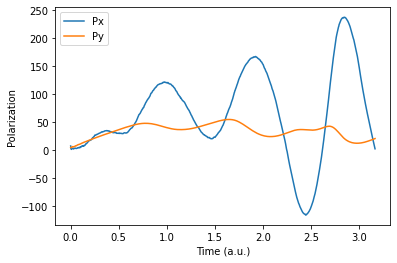

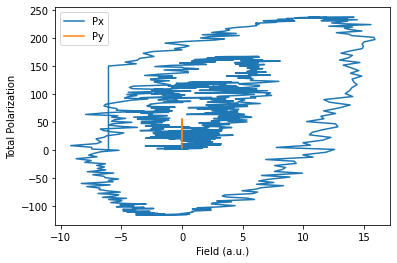

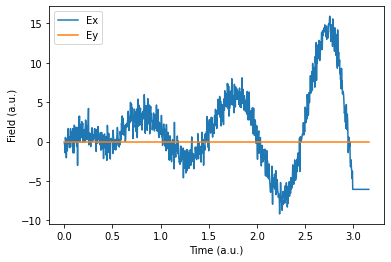

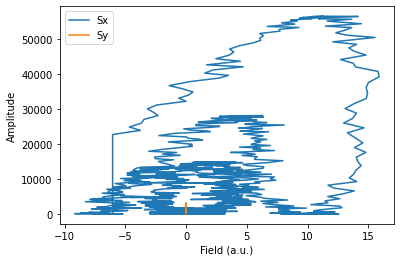

In [ ]:
sim.plot_summary()

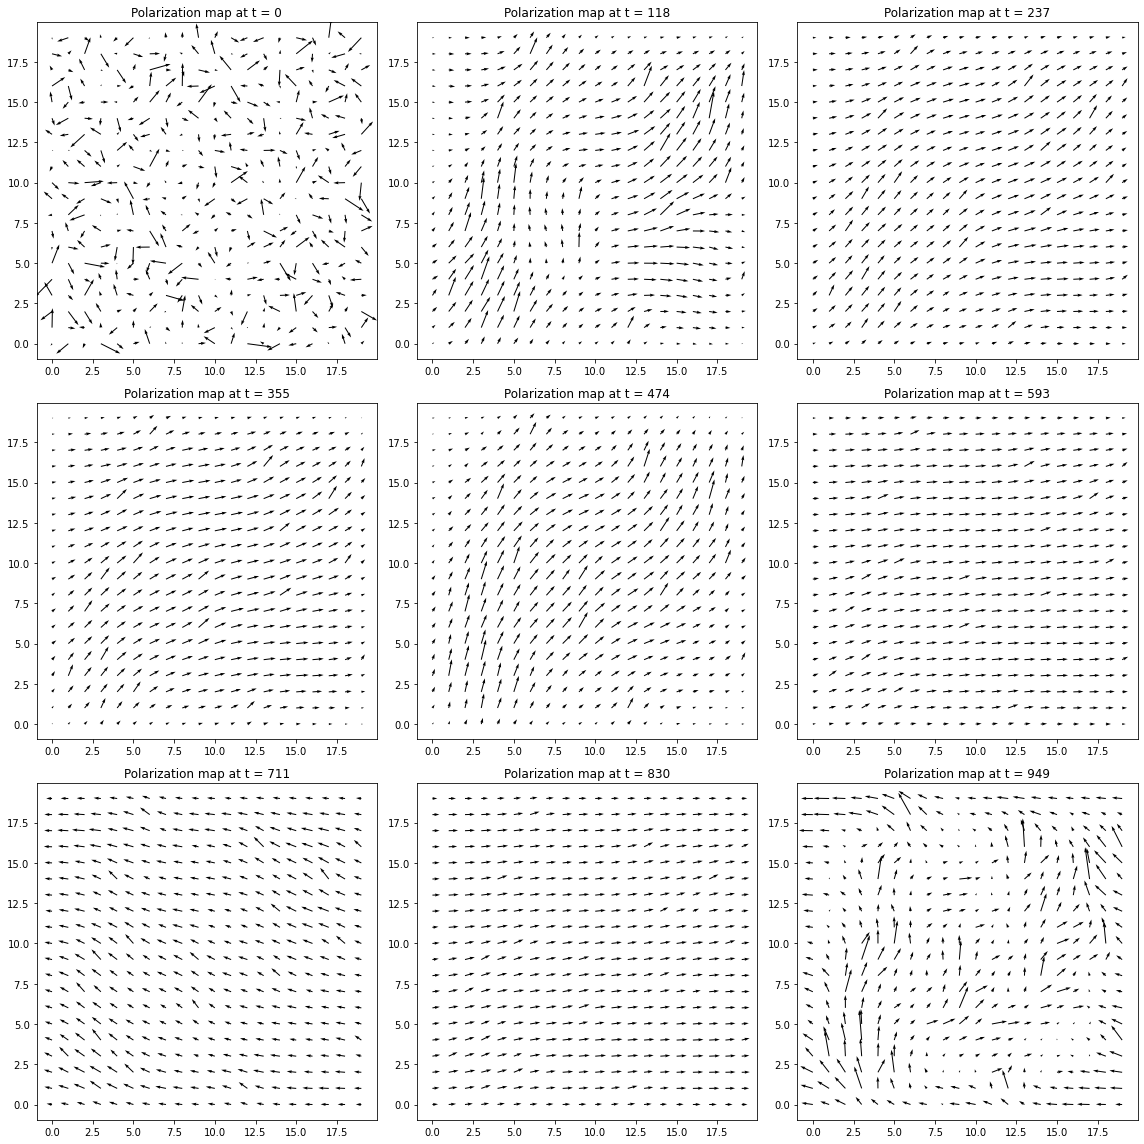

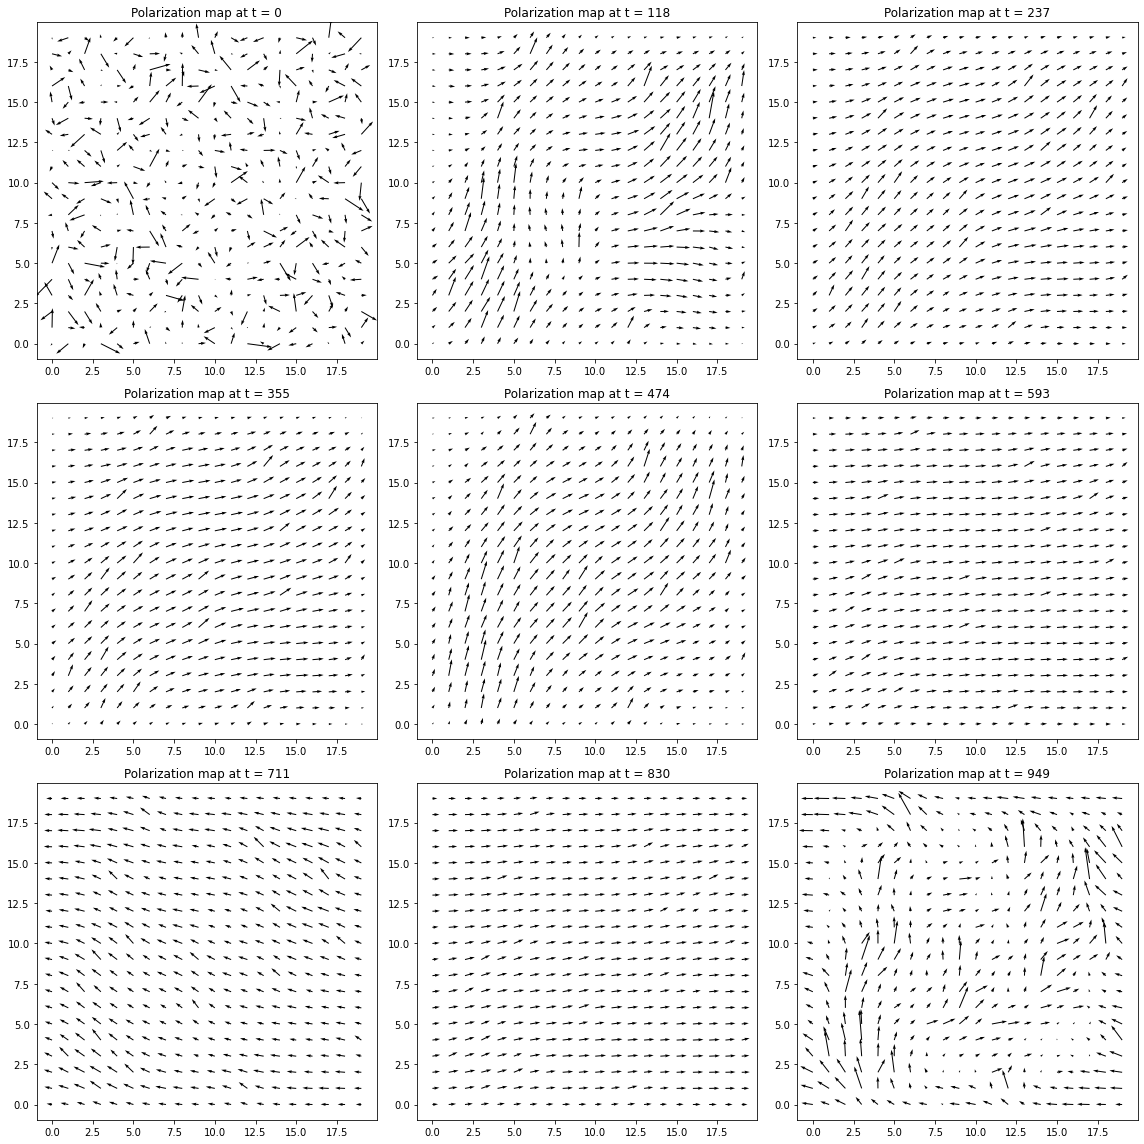

In [ ]:
sim.plot_quiver()

In [ ]:
# Curls calculation
curls = np.zeros(Pmats.shape[0])
for i, pmat in enumerate(Pmats):
    curls[i] = np.sum(np.abs(sim.calc_curl(pmat)))
    
curls = curls.reshape([100, 100])

In [ ]:
np.save('curls.npy', curls)

In [ ]:
#Here we download the coordinates of the important points in the curl surface, These points were hand picked
!gdown 1meucfDTE_pPBGKy7lQaPDGb0EXUoBgWv
imp_points = np.load('imp_points.npy')

Downloading...
From: https://drive.google.com/uc?id=1meucfDTE_pPBGKy7lQaPDGb0EXUoBgWv
To: /content/imp_points.npy
100% 200/200 [00:00<00:00, 327kB/s]


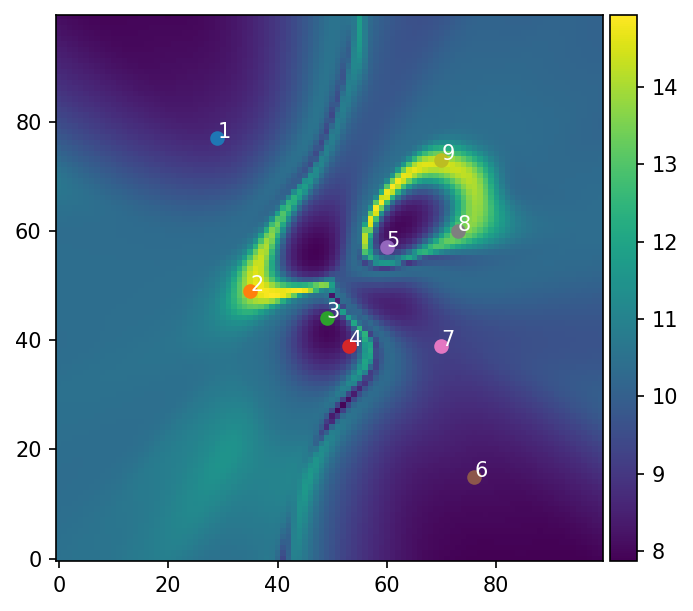

In [ ]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 150)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(curls, origin = 'lower')
fig.colorbar(im, cax=cax, orientation='vertical')

for i in range(9):
    ax.scatter(imp_points[i, 1], imp_points[i, 0])
    ax.annotate(str(i+1), (imp_points[i, 1], imp_points[i, 0]), c = 'w')

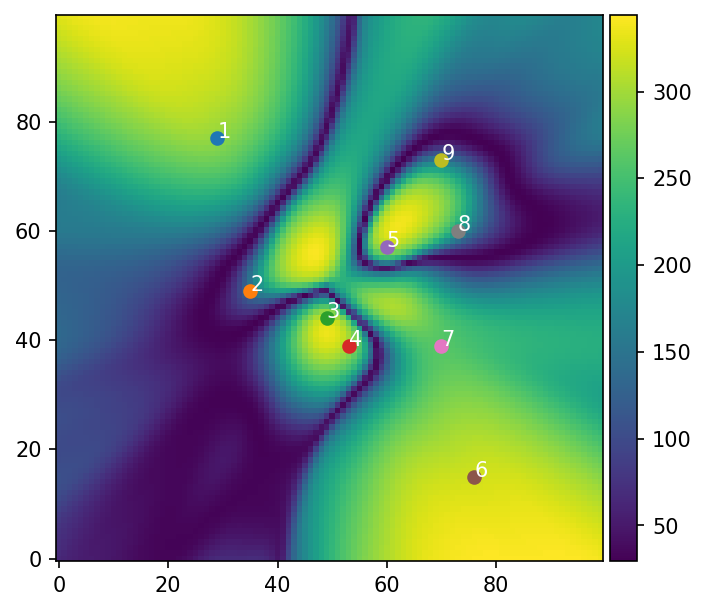

In [ ]:
# Calculating the total Polarization at the end of simulations
P_total = np.zeros([10000])
for i, pvals in enumerate(Pmats):
    P_total[i] = np.sum(np.sqrt(np.sum(pvals**2, axis = 0)))

P_total = P_total.reshape([100,100])

fig, ax = plt.subplots(figsize = (5,5), dpi = 150)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(P_total, origin = 'lower')
fig.colorbar(im, cax=cax, orientation='vertical')

for i in range(9):
    ax.scatter(imp_points[i, 1], imp_points[i, 0])
    ax.annotate(str(i+1), (imp_points[i, 1], imp_points[i, 0]), c = 'w')

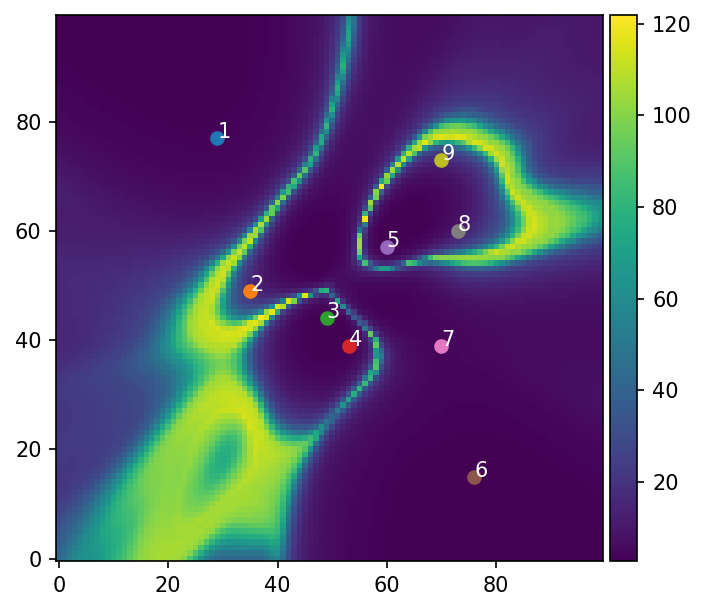

In [ ]:
# Calculating the normalized curl

#Magnitude of polarization field
punits = np.zeros([10000, 20, 20])
for i, pmat in enumerate(Pmats):
    punits[i] = (np.sqrt(np.sum(pmat**2, axis = 0)))   

normalized_curl = np.zeros(Pmats.shape[0])
for i, pmat in enumerate(Pmats):
    pass
    pmat_unit = pmat/(punits[i])
    normalized_curl[i] = np.sum(np.abs(sim.calc_curl(pmat_unit)))
    
normalized_curl = normalized_curl.reshape([100, 100])


fig, ax = plt.subplots(figsize = (5,5), dpi = 150)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(normalized_curl, origin = 'lower')
fig.colorbar(im, cax=cax, orientation='vertical')

for i in range(9):
    ax.scatter(imp_points[i, 1], imp_points[i, 0])
    ax.annotate(str(i+1), (imp_points[i, 1], imp_points[i, 0]), c = 'w')

# Bayesian Optimization of Latent space

In [ ]:
# Instead of running the actual simulation, 
# we can use the curls calculated above using the brute force as the target value for BO
!gdown 1_ymJfuvweIRaweey-2rn0LxVFSMgqGnK
curls = np.load('curls.npy')
curls_norm = (curls - np.amin(curls))/(np.ptp(curls))

Downloading...
From: https://drive.google.com/uc?id=1_ymJfuvweIRaweey-2rn0LxVFSMgqGnK
To: /content/curls.npy
100% 80.1k/80.1k [00:00<00:00, 72.8MB/s]


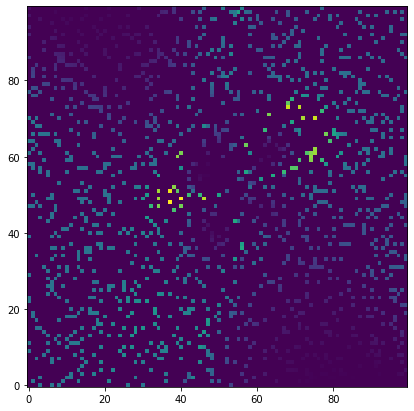

In [ ]:
# Create a 2D function
def quality_func(input_arr):
  return curls_norm[input_arr[0], input_arr[1]]

np.random.seed(512)
size_L1, size_L2 = 100, 100
Z_sparse = np.ones((size_L1, size_L1))*np.nan
# We will start by feeding 15% of the points as the seed points
idx = np.random.randint(0, Z_sparse.shape[0], size=(1500, 2))

for i in idx:
    Z_sparse[i[0], i[1]] = quality_func([i[0], i[1]])

fig, ax = plt.subplots(figsize = (7,7))
ax.imshow(np.nan_to_num(Z_sparse), origin = 'lower')

In [ ]:
import random
#Custom acquisition function
def acq2(gpmodel, X_full, X_sparse):  # leave it as is

    mean, sd = gpmodel.predict(X_full, verbose=0) # leave it as is
    if np.random.rand() > 0.6:
      acq = mean
    else:  # We will do a random sampling here
      acq = np.random.rand(100, 100)
    
    return acq, (mean, sd)  # leave it as is

In [ ]:
# THIS CELL TAKES A COUPLE OF HOURS TO RUN WITH A GPU
# Results can be downloaded in the next cell by skipping this cell
X_full = gpim.utils.get_full_grid(Z_sparse)
X_sparse= gpim.utils.get_sparse_grid(Z_sparse)

boptim = gpim.boptimizer(
    X_sparse, Z_sparse, X_full, 
    quality_func, acquisition_function=acq2,
    exploration_steps=100,
    batch_update=False,
    learning_rate = 0.1, kernel = 'Matern52',
    gp_iterations=800, gamma = 1,
    dscale = 4, memory = 1000,
    use_gpu=True, verbose=1)
# Run Bayesian optimization
boptim.run()

# Plot exploration history
gpim.utils.plot_query_points(boptim.indices_all, plot_lines=True)

vals_all = np.array(boptim.vals_all)
func_val, gp_pred = boptim.target_func_vals, boptim.gp_predictions
inds_all = np.array(boptim.indices_all)

results = {}
results['gp_pred'] = gp_pred
results['func_val'] = func_val
results['inds_all'] = inds_all
results['vals_all'] = vals_all

import pickle
pickle.dump( results, open('ferrosim_gpim_results.p', "wb" ))

In [ ]:
# Downloading the results
!gdown 1hVtVXeqWXV6LKaIT5SCicmG5bmubDfjE

with open(r"ferrosim_gpim_results.p", "rb") as input_file:
  results = pickle.load(input_file)

gp_pred = results['gp_pred']
func_val = results['func_val']
inds_all = results['inds_all']
vals_all = results['vals_all']

Downloading...
From: https://drive.google.com/uc?id=1hVtVXeqWXV6LKaIT5SCicmG5bmubDfjE
To: /content/ferrosim_gpim_results.p
100% 24.1M/24.1M [00:00<00:00, 177MB/s]


Text(0.5, 1.0, 'Ground_truth')

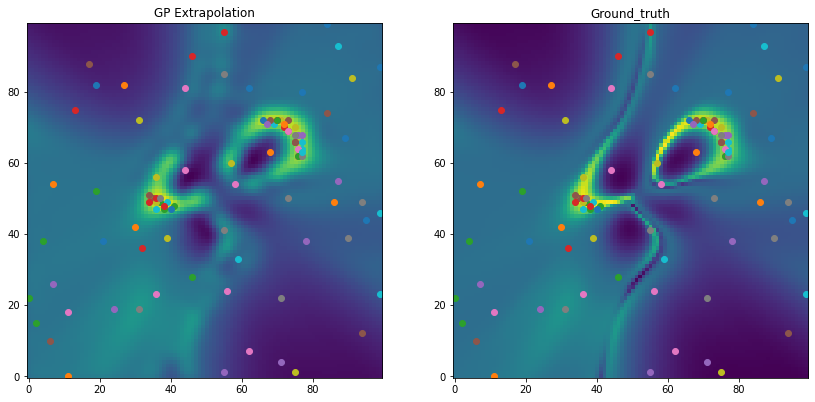

In [ ]:
# Explored points on the GP extrapolation of the curl surface and on the actual curl surface
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14,7))
ax[0].imshow(gp_pred[-1][0], origin = 'lower')
ax[1].imshow(curls_norm, origin = 'lower')
for ind in inds_all:
  ax[0].scatter(ind[1], ind[0])
  ax[1].scatter(ind[1], ind[0])

ax[0].set_title('GP Extrapolation')
ax[1].set_title('Ground_truth')